In [1]:
# Figure 2 shows distribution of numbers of SNP changes in QP pairs

In [2]:
from utils import config, parse_midas_data, sample_utils as su, temporal_changes_utils, stats_utils, midas_db_utils, parse_patric
from collections import defaultdict
import numpy as np
from numpy.random import binomial as sample_binomial
import math
import pickle
import sys
import random
from math import log10,ceil,log,exp

import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.patches import Patch

# Cohort list
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'olm', 'hmp']

# Plot directory
plot_dir = "%s/" % (config.analysis_directory)

# Species list
good_species_list = parse_midas_data.load_pickled_good_species_list()

# Sample-subject-order maps
sys.stderr.write("Loading sample metadata...\n")
subject_sample_map = su.parse_subject_sample_map()
sample_order_map = su.parse_sample_order_map()
sample_subject_map = su.parse_sample_subject_map()
same_mi_pair_dict = su.get_same_mi_pair_dict(subject_sample_map)
sys.stderr.write("Done!\n")

# Timepoint pair types
tp_pair_names = ['MM', 'MI', 'II', 'AA']

# Cohorts
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'hmp']
mi_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

# Samples for each cohort
samples = {cohort: su.get_sample_names(cohort) for cohort in cohorts}
hmp_samples = su.get_sample_names('hmp')
mother_samples = su.get_sample_names('mother')
infant_samples = su.get_sample_names('infant')
olm_samples = su.get_sample_names('olm')
infant_samples_no_olm = [sample for sample in infant_samples if sample not in olm_samples]
mi_samples_no_olm = [sample for sample in (mother_samples + infant_samples) if sample not in olm_samples]

# Sample-cohort map
sample_cohort_map = su.parse_sample_cohort_map()

# Sample-timepoint map
mi_sample_day_dict = su.get_mi_sample_day_dict(exclude_cohorts=['olm'])
mi_tp_sample_dict = su.get_mi_tp_sample_dict(exclude_cohorts=['olm']) # no binning
mi_tp_sample_dict_binned, mi_tp_binned_labels = su.get_mi_tp_sample_dict(exclude_cohorts=['olm'], binned=True)

Loading sample metadata...
Done!


In [3]:
# ======================================================================
# Load pickled data
# ======================================================================

# Parameters
sweep_type = 'full' # assume full for now
pp_prev_cohort = 'all'
min_coverage = 0

ddir = config.data_directory
pdir = "%s/pickles/cov%i_prev_%s/" % (ddir, min_coverage, pp_prev_cohort)

snp_changes = pickle.load(open('%s/big_snp_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_changes = pickle.load(open('%s/big_gene_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
snp_change_freqs = pickle.load(open('%s/snp_change_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
snp_change_null_freqs = pickle.load(open('%s/snp_change_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_gain_freqs = pickle.load(open('%s/gene_gain_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_freqs = pickle.load(open('%s/gene_loss_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_null_freqs = pickle.load(open('%s/gene_loss_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
between_snp_change_counts = pickle.load(open('%s/between_snp_change_counts_%s.pkl' % (pdir, sweep_type), 'rb'))
between_gene_change_counts = pickle.load(open('%s/between_gene_change_counts_%s.pkl' % (pdir, sweep_type), 'rb'))

In [4]:
# Define function needed for survival curve plots

def calculate_unnormalized_survival_from_vector(counts):
    counts = sorted(counts)
    xs = []
    ns = []
    ns_cur = len(counts)
    min = -1
    for count in counts:
        if count > min:
            ns.append(ns_cur) # Number of elements greater or equal
            xs.append(count)
            min = count
        ns_cur -= 1
    xs.append(xs[len(xs)-1]+1)
    ns.append(0)
    return xs, np.array(ns)

In [5]:
# Calculate number of days for a timepoint pair

mi_sample_day_dict = su.get_mi_sample_day_dict()

def sample_pair_to_days(sample1, sample2):
    days = mi_sample_day_dict[sample2] - mi_sample_day_dict[sample1]
    if days < 0:
        return np.abs(days)
    return days

def tp_pair_to_days(tp_pair):
    tpa, tpb = tp_pair
    o1 = float(tpa[1:])
    o2 = float(tpb[1:])
    return np.abs(o1-o2)

# Rough approximation of HMP time intervals
def adult_tp_pair_to_days(tp_pair):
    tpa, tpb = tp_pair
    return np.abs(int(tpa[-1:]) - int(tpb[-1:]))*183

def tp_pair_to_tp_type(tp_pair):
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type == 'IM':
        tp_type = 'MI'
    return tp_type

In [6]:
# Custom sample pair cohorts [not just sample!]

def custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j):
            return cohort

custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['Day 0-Week 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7))
custom_cohort_tests['Week 1-Month 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 7 and mi_sample_day_dict[sample_j] <= 31))
custom_cohort_tests['Month 1-Year 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 31 and mi_sample_day_dict[sample_j] <= 400))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

# Make pooled snp change distributions from snp_changes

pooled_snp_change_distribution = defaultdict(list)
pooled_between_snp_change_distribution = defaultdict(list)

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        # if sample_i in mother_samples and sample_j in infant_samples:
            # print("%i > %i" % (mi_sample_day_dict[sample_i], mi_sample_day_dict[sample_j]))
        # if sample_j in mother_samples and sample_i in infant_samples:
            # print("%i < %i" % (mi_sample_day_dict[sample_i], mi_sample_day_dict[sample_j]))
        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        pooled_snp_change_distribution[custom_cohort].append(num_snp_changes)
        
        num_snp_changes_between = between_snp_change_counts[species][(sample_i, sample_j)]
        if sample_i in hmp_samples and sample_j in hmp_samples:
            pooled_between_snp_change_distribution['AA'].append(num_snp_changes_between)
        else:
            pooled_between_snp_change_distribution['MI'].append(num_snp_changes_between)

In [8]:
# Plot SNP change distribution with all infant-infant QP pairs combined

custom_cohort_tests = {}
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['II-1mon'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (sample_pair_to_days(sample_i, sample_j) <= 32))
custom_cohort_tests['II-1yr'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (sample_pair_to_days(sample_i, sample_j) > 90))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

pooled_snp_change_distribution = defaultdict(list)
pooled_between_snp_change_distribution = defaultdict(list)

time_length_dist = []

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if custom_cohort == 'II-1yr':
            time_length_dist.append(sample_pair_to_days(sample_i, sample_j))
        pooled_snp_change_distribution[custom_cohort].append(num_snp_changes)
        
        num_snp_changes_between = between_snp_change_counts[species][(sample_i, sample_j)]
        if sample_i in hmp_samples and sample_j in hmp_samples:
            pooled_between_snp_change_distribution['AA'].append(num_snp_changes_between)
        else:
            pooled_between_snp_change_distribution['MI'].append(num_snp_changes_between)

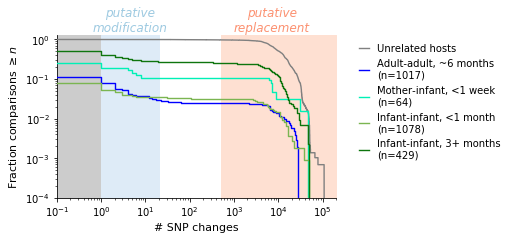

In [9]:
fig_snp, ax_snp = plt.subplots(figsize=(5,3))

colormap = cmx.get_cmap('viridis', 8)
colors = [colormap(x) for x in np.array([x for x in range(0,8)])/8.0]
colors = ['gray', 'blue', '#00f0b6', '#7bb551', '#0e750e']

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold

ax_snp.set_xscale('log')
ax_snp.set_yscale('log')
ax_snp.set_ylabel('Fraction comparisons $\geq n$', fontsize=11)
ax_snp.set_xlabel('# SNP changes', fontsize=11)

ax_snp.spines['top'].set_visible(False)
ax_snp.spines['right'].set_visible(False)
ax_snp.get_xaxis().tick_bottom()
ax_snp.get_yaxis().tick_left()

color_i = 0

ymin, ymax = 0.0001, 1.3
ax_snp.set_ylim([ymin,ymax])
xmin, xmax = 1e-01, 2e05
ax_snp.set_xlim([xmin, xmax])

# Now fill in the graphics

ax_snp.fill_between([xmin,1], [ymin,ymin],[ymax,ymax],color='0.8',zorder=1)
ax_snp.fill_between([1,modification_difference_threshold],[ymin,ymin],[ymax,ymax],color='#deebf7',zorder=1)
ax_snp.fill_between([replacement_difference_threshold,xmax],[ymin,ymin],[ymax,ymax],color='#fee0d2',zorder=1)

ax_snp.text( exp((log(1e05)+log(replacement_difference_threshold))/2), ymax*1.2, 'putative\nreplacement',fontsize=12,fontstyle='italic',ha='center',color='#fc9272',zorder=1)
ax_snp.text( exp((log(1)+log(modification_difference_threshold))/2), ymax*1.2, 'putative\nmodification',fontsize=12,fontstyle='italic',ha='center',color='#9ecae1',zorder=1)
'''
# Unrelated adults
counts = pooled_between_snp_change_distribution['AA']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated adults", where='pre',zorder=4)
color_i += 1

# Unrelated mother/infant
counts = pooled_between_snp_change_distribution['MI']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated mothers/infants", where='pre',zorder=4)
color_i += 1

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_infant_combined_a1.png' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)
'''

# Unrelated hosts (adults OR mother/infant)
counts = pooled_between_snp_change_distribution['AA'] + pooled_between_snp_change_distribution['MI']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated hosts", where='pre',zorder=4)
color_i += 1

# Within-host, adult
counts = pooled_snp_change_distribution['AA']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = 'Adult-adult, ~6 months' + ('\n(n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, mother-infant
counts = pooled_snp_change_distribution['MI']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = "Mother-infant, <1 week" + ('\n(n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, infant-infant
for infant_custom_cohort, infant_custom_label in zip(['II-1mon', 'II-1yr'], ['Infant-infant, <1 month', 'Infant-infant, 3+ months']):
    counts = pooled_snp_change_distribution[infant_custom_cohort]
    xs, ns = calculate_unnormalized_survival_from_vector(counts)
    mlabel = ('%s\n(n=%d)' % (infant_custom_label, ns[0]))
    ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
    color_i += 1

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1, frameon=False)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_infant_combined_v2.pdf' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)
plt.show()